In [2]:
%%capture
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

In [3]:
import torch

In [4]:
names = open('names.txt').read().splitlines()

In [ ]:
b = {}

for name in names:
    name = ['<s>'] + list(name) + ['</s>']
    for chr1, chr2 in zip(name, name[1:]):
        bigram = (chr1, chr2)
        b[bigram] = b.get(bigram, 0) + 1

In [ ]:
out = ''
start = '<s>'

f = {k[1]:v for k, v in b.items() if k[0] == start}
l = sorted(f.items(), key=lambda kv: -kv[1])[0][0]
out += l
start = l

f = {k[1]:v for k, v in b.items() if k[0] == start}
l = sorted(f.items(), key=lambda kv: -kv[1])[0][0]
out += l
start = l

# f = {k[1]:v for k, v in b.items() if k[0] == start}
# l = sorted(f.items(), key=lambda kv: -kv[1])[0][0]
# out += l
# start = l

out

In [5]:
vocab = sorted(set(''.join(names) + '.'))
stoi = {v:k for k, v in enumerate(vocab)}
itos = {v:k for k, v in stoi.items()}

In [6]:
import matplotlib.pyplot as plt

In [7]:
# Training statistical bigram model
N = torch.zeros((27, 27), dtype=torch.long)

for name in names:
    name = ['.'] + list(name) + ['.']
    for chr1, chr2 in zip(name, name[1:]):
        ix1 = stoi[chr1]
        ix2 = stoi[chr2]
        N[ix1, ix2] += 1

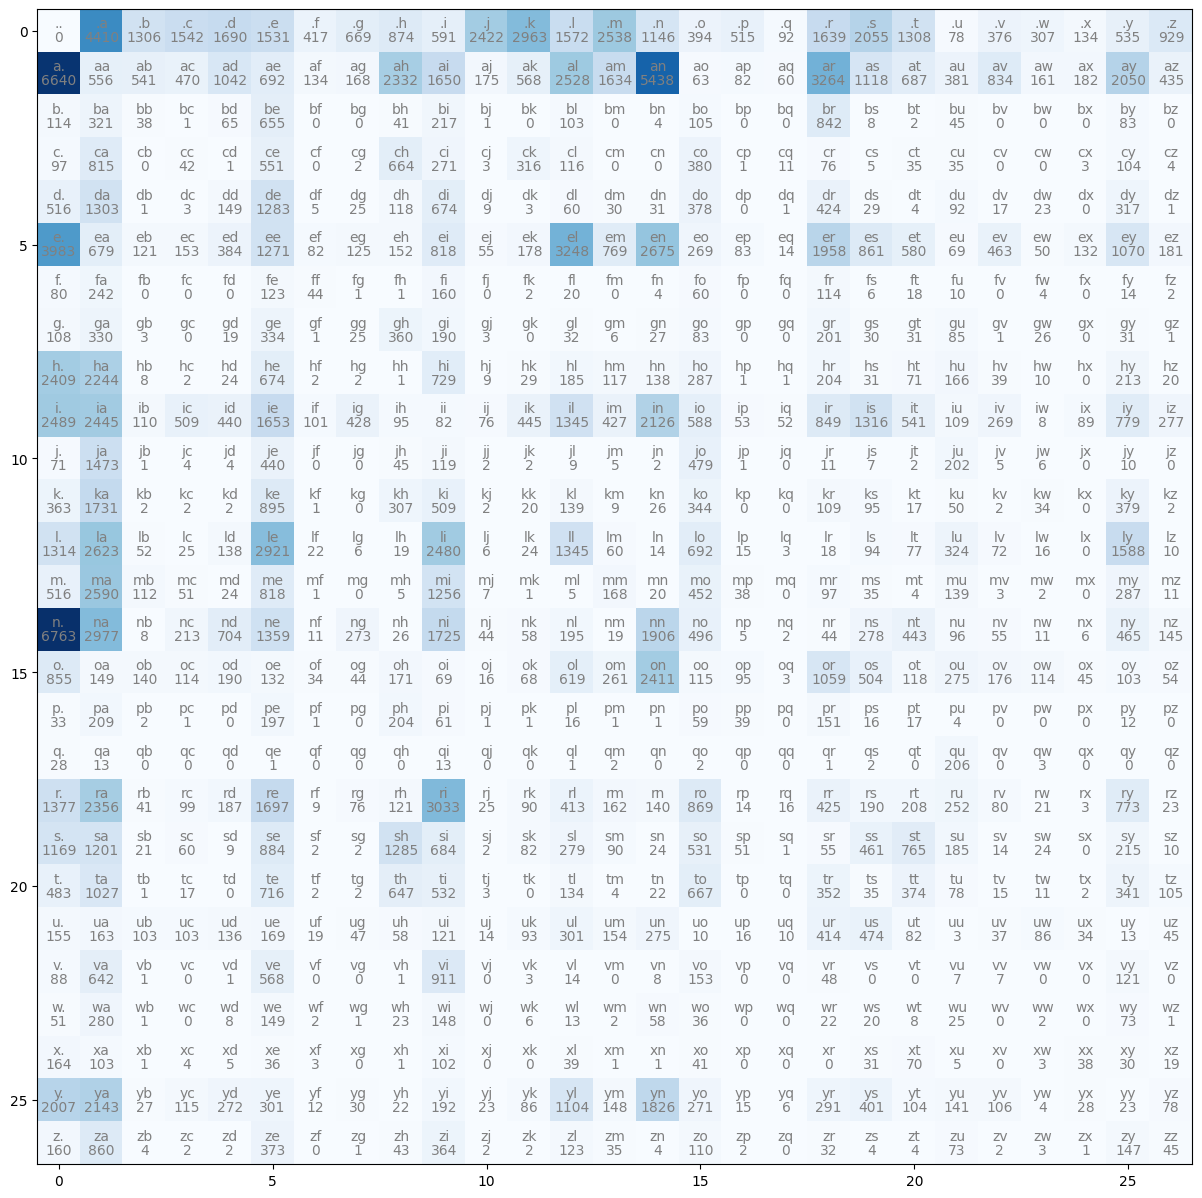

In [8]:
plt.figure(figsize=(15, 15))
plt.imshow(N, cmap='Blues')

for i in range(27):
    for j in range(27):
        plt.text(j, i, itos[i] + itos[j], ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')

In [ ]:
def decode(seq: list[int]) -> str:
    return ''.join([itos[i] for i in seq])

In [9]:
P = N.float()
P = P / P.sum(dim=1, keepdim=True)

In [12]:
context = 1

# inference
probs = P[context]

tensor([0.1960, 0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688,
        0.0487, 0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018,
        0.0963, 0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128])

In [ ]:
for _ in range(10):
    out = []
    ix = 0

    while True:
        p = P[ix]
        # p = torch.ones((27,), dtype=torch.float) / 27.0
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(ix)

        if ix == 0:
            break

    print(decode(out))

# Homework: build 3-gram model

In [1]:
import torch

In [15]:
len(names)

32033

In [19]:
test_size = int(0.2 * len(names))
test_size

6406

In [106]:
tr_names = names[:-test_size]
ts_names = names[-test_size:]

### Unigram

In [30]:
N1 = torch.zeros(27, dtype=torch.long)

for name in tr_names:
    name = name + '.'
    for chr in name:
        ix = stoi[chr]
        N1[ix] += 1

In [59]:
N1

tensor([25627, 28314,  2042,  2737,  4115, 16545,   682,  1523,  6039, 14544,
         2171,  3873, 11967,  5278, 14662,  5724,   798,   173,  9875,  6280,
         4313,  2246,  1966,   648,   498,  8277,  1867])

In [34]:
P1 = N1.float()
P1 /= P1.sum()

In [43]:
P1

tensor([0.1402, 0.1549, 0.0112, 0.0150, 0.0225, 0.0905, 0.0037, 0.0083, 0.0330,
        0.0796, 0.0119, 0.0212, 0.0655, 0.0289, 0.0802, 0.0313, 0.0044, 0.0009,
        0.0540, 0.0344, 0.0236, 0.0123, 0.0108, 0.0035, 0.0027, 0.0453, 0.0102])

In [50]:
# Unigram inference

out = []
while True:
    ix = torch.multinomial(P1, num_samples=1).item()
    out.append(itos[ix])
    if ix == 0:
        break
print(''.join(out))


jtnseikin.


### Bigram

In [53]:
N2 = torch.zeros((27, 27), dtype=torch.long)

for name in tr_names:
    name = '.' + name + '.'
    for chr1, chr2 in zip(name, name[1:]):
        ix1 = stoi[chr1]
        ix2 = stoi[chr2]
        N2[ix1, ix2] += 1

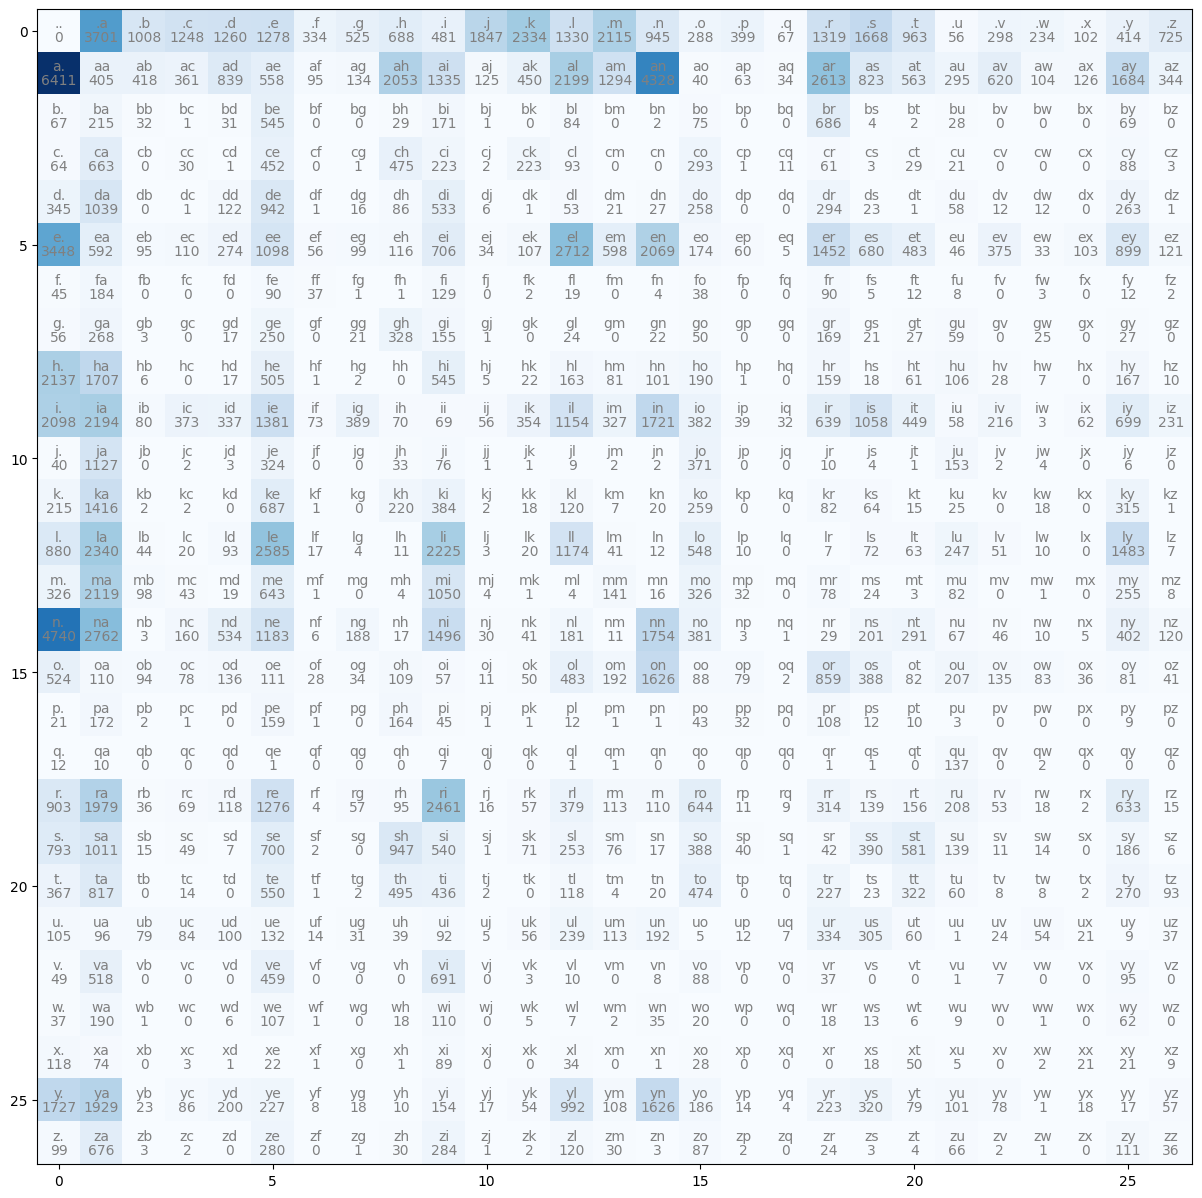

In [61]:
plt.figure(figsize=(15, 15))
plt.imshow(N2, cmap='Blues')

for i in range(27):
    for j in range(27):
        plt.text(j, i, itos[i] + itos[j], ha='center', va='bottom', color='gray')
        plt.text(j, i, N2[i, j].item(), ha='center', va='top', color='gray')

In [109]:
P2 = (N2 + 1).float() # Laplace smoothing
P2 /= P2.sum(1, keepdim=True)

In [66]:
(N2 == 0).sum() / N2.nelement()

tensor(0.1783)

$$
log(a*b*c) = log(a) + log(b) + log(c)
$$

In [119]:
# calculating the loss

log_likelihood = 0
n = 0
for name in tr_names:
    name = '.' + name + '.'
    for chr1, chr2 in zip(name, name[1:]):
        prob = P2[stoi[chr1], stoi[chr2]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

# negative log likelihood loss or cross entropy
nll = -log_likelihood / n
nll

tensor(2.4249)

In [120]:
# calculating the loss

log_likelihood = 0
n = 0
for name in ts_names:
    name = '.' + name + '.'
    for chr1, chr2 in zip(name, name[1:]):
        prob = P2[stoi[chr1], stoi[chr2]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

# negative log likelihood loss or cross entropy
nll = -log_likelihood / n
nll

tensor(2.5936)

### Trigram

In [55]:
N3 = torch.zeros((27, 27, 27), dtype=torch.long)

for name in tr_names:
    name = '..' + name + '.'
    for chr1, chr2, chr3 in zip(name, name[1:], name[2:]):
        ix1 = stoi[chr1]
        ix2 = stoi[chr2]
        ix3 = stoi[chr3]
        N3[ix1, ix2, ix3] += 1

In [116]:
P3 = (N3+1).float()
P3 /= P3.sum(2, keepdim=True)

In [67]:
N3.nelement()

19683

In [68]:
(N3 == 0).sum()

tensor(14232)

In [70]:
(N3 == 0).sum() / N3.nelement()

tensor(0.7231)

In [121]:
# calculating the loss

log_likelihood = 0
n = 0
for name in tr_names:
    name = '..' + name + '.'
    for chr1, chr2, chr3 in zip(name, name[1:], name[2:]):
        prob = P3[stoi[chr1], stoi[chr2], stoi[chr3]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

# negative log likelihood loss or cross entropy
nll = -log_likelihood / n
nll

tensor(2.1763)

In [122]:
# calculating the loss

log_likelihood = 0
n = 0
for name in ts_names:
    name = '..' + name + '.'
    for chr1, chr2, chr3 in zip(name, name[1:], name[2:]):
        prob = P3[stoi[chr1], stoi[chr2], stoi[chr3]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

# negative log likelihood loss or cross entropy
nll = -log_likelihood / n
nll

tensor(2.4267)

### 4-gram

In [71]:
N4 = torch.zeros((27, 27, 27, 27), dtype=torch.long)

for name in tr_names:
    name = '...' + name + '.'
    for chr1, chr2, chr3, chr4 in zip(name, name[1:], name[2:], name[3:]):
        ix1 = stoi[chr1]
        ix2 = stoi[chr2]
        ix3 = stoi[chr3]
        ix4 = stoi[chr3]
        N4[ix1, ix2, ix3, ix4] += 1

In [73]:
N4.nelement()

531441

In [75]:
(N4 == 0).sum()

tensor(526334)

In [76]:
(N4 == 0).sum() / N4.nelement()

tensor(0.9904)

In [118]:
P4 = (N4+1).float()
P4 /= P4.sum(3, keepdim=True)

In [123]:
# calculating the loss

log_likelihood = 0
n = 0
for name in tr_names:
    name = '...' + name + '.'
    for chr1, chr2, chr3, chr4 in zip(name, name[1:], name[2:], name[3:]):
        prob = P4[stoi[chr1], stoi[chr2], stoi[chr3], stoi[chr4]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

# negative log likelihood loss or cross entropy
nll = -log_likelihood / n
nll

tensor(5.8467)

In [124]:
# calculating the loss

log_likelihood = 0
n = 0
for name in ts_names:
    name = '...' + name + '.'
    for chr1, chr2, chr3, chr4 in zip(name, name[1:], name[2:], name[3:]):
        prob = P4[stoi[chr1], stoi[chr2], stoi[chr3], stoi[chr4]]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

# negative log likelihood loss or cross entropy
nll = -log_likelihood / n
nll

tensor(5.6962)

## Neural Network Approach

$$
P(w_i | \text{context})
$$

# Self-Supervised Learning

In [145]:
import torch.nn.functional as F

In [136]:
names[:3]

['emma', 'olivia', 'ava']

In [140]:
X = []
Y = []

for name in tr_names:
    name = '.' + name + '.'
    for ch1, ch2 in zip(name, name[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        Y.append(ix2)

X = torch.tensor(X)
Y = torch.tensor(Y)

In [141]:
X

tensor([ 0,  5, 13,  ..., 25, 26, 24])

In [142]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [156]:
xenc = F.one_hot(X, num_classes=27).float()

In [157]:
xenc

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])

In [187]:
W = torch.randn(27, 27, requires_grad=True)

In [195]:
for i in range(1000):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)

    nll = -probs[torch.arange(len(X)), Y].log().mean() # calc loss
    if i % 100 == 0:
        print("Loss:", nll.item())

    W.grad = None # zero grad
    nll.backward()
    W.data += -1 * W.grad # update parameters

Loss: 3.773411512374878
Loss: 3.1746795177459717
Loss: 2.9242866039276123
Loss: 2.7920305728912354
Loss: 2.7142333984375
Loss: 2.66453218460083
Loss: 2.630662679672241
Loss: 2.6062965393066406
Loss: 2.5878992080688477
Loss: 2.5734384059906006


- Move model and X, Y into GPU
- Make inferene using trained model
- Try the model with more complex settings
- Try to beat the statistical bigram model (test set loss = 2.5936)

In [197]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [198]:
device

device(type='cpu')